In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import KFold
  
from ucimlrepo import fetch_ucirepo

abalone = fetch_ucirepo(id = 1)
print(abalone.variables)

data = abalone.data.original.to_numpy()

# Getting rid of observations with 0 height, or with a height too large (as specified in the first report)
data = data[data[:, 3] != 0]
data = data[data[:, 3] < 0.5]
        
print(np.shape(data))

             name     role         type demographic  \
0             Sex  Feature  Categorical        None   
1          Length  Feature   Continuous        None   
2        Diameter  Feature   Continuous        None   
3          Height  Feature   Continuous        None   
4    Whole_weight  Feature   Continuous        None   
5  Shucked_weight  Feature   Continuous        None   
6  Viscera_weight  Feature   Continuous        None   
7    Shell_weight  Feature   Continuous        None   
8           Rings   Target      Integer        None   

                   description  units missing_values  
0         M, F, and I (infant)   None             no  
1    Longest shell measurement     mm             no  
2      perpendicular to length     mm             no  
3           with meat in shell     mm             no  
4                whole abalone  grams             no  
5               weight of meat  grams             no  
6  gut weight (after bleeding)  grams             no  
7        

- - -
- - -
# 1. Regression (part 1)

## 1.1. Data preparation
> **Exercise**
> 
> Explain what variable is predicted based on which other variables and what you hope to accomplish by the regression. 
> Mention your feature transformation choices such as one-of-K coding. 
> Since we will use regularization momentarily, apply a feature transformation to your data matrix X such that each column has mean $0$ and standard deviation $1$.

### 1.1.1. Objective


### 1.1.2. One-hot encoding
We decided to use the one-hot encoding to transform the first attribute, which is the gender of the abalone: intially assuming values 'M', 'F', and 'I' for male, female, and infant, we encode the values by replacing the column with three different columns, one for each gender, in which the values are 1 if the original value was the gender, and 0 otherwise.

In [20]:
def encode_sex_column(data):
    # Extract sex column
    sex_column = data[:, 0]
    
    # convert to 0 and 1
    male = (sex_column == 'M').astype(int)
    female = (sex_column == 'F').astype(int)
    infant = (sex_column == 'I').astype(int)
    
    # Stack horizontally
    encoded = np.column_stack((male, female, infant))
    
    # Combine with rest of data (excluding original sex column)
    encoded_data = np.column_stack((encoded, data[:, 1:]))
    
    return encoded_data

### 1.1.3. Data standardization
We also need to standardize the data to have mean 0 and standard deviation 1.

In [21]:
def standardize_data(data):
    # Standardize remaining columns
    numeric_cols = data.astype(float)
    
    # Calculate mean and std for each column
    means = np.mean(numeric_cols, axis=0)
    stds = np.std(numeric_cols, axis=0)
    
    # Standardize: (X - mean) / std
    standardized_cols = (numeric_cols - means) / stds
    
    return standardized_cols, means, stds

In [22]:
encoded_data = encode_sex_column(data)
standardized_data, _, _ = standardize_data(encoded_data)
X, y = standardized_data[:, :-1], standardized_data[:, -1:]

print(f'Input:\n{X}\n\nOutput:\n{y}')

Input:
[[ 1.3163622  -0.67492846 -0.68774764 ... -0.60810552 -0.72681646
  -0.63809109]
 [ 1.3163622  -0.67492846 -0.68774764 ... -1.17198596 -1.20621735
  -1.21298966]
 [-0.75966934  1.48163851 -0.68774764 ... -0.46375213 -0.35699291
  -0.20691716]
 ...
 [ 1.3163622  -0.67492846 -0.68774764 ...  0.74971856  0.97619814
   0.49733359]
 [-0.75966934  1.48163851 -0.68774764 ...  0.7745293   0.73421483
   0.4110988 ]
 [ 1.3163622  -0.67492846 -0.68774764 ...  2.64435681  1.78889679
   1.841159  ]]

Output:
[[ 1.57063184]
 [-0.91039274]
 [-0.29013659]
 ...
 [-0.29013659]
 [ 0.01999148]
 [ 0.64024763]]


### 1.1.4. Linear regression
We now implement a basic linear regression model that can solve analytically for the weights.

In [23]:
from Regression.LinearRegression import LinearRegression

model = LinearRegression(X, y)
model.solve_analytical()
scores = model.score()

print(f"R² Score: {scores['R2']:.4f}")
print(f"MSE: {scores['MSE']:.4f}")

R² Score: 0.5439
MSE: 0.4561


- - -
## 1.2. Regularization

### 1.2.1. Analytical solution
Even if we pass a regularization value for lambda, we can still solve the linear regression analytically using the following formula:

$$$$

In [24]:
model.solve_analytical(lambda_=10)
scores = model.score()

print(f"R² Score: {scores['R2']:.4f}")
print(f"MSE: {scores['MSE']:.4f}")

R² Score: 0.5426
MSE: 0.4574


### 1.2.2. Regularization path
Then we can write a method for plotting the mean coefficient values, which shows the weights of each feature as a function of the regularization parameter.

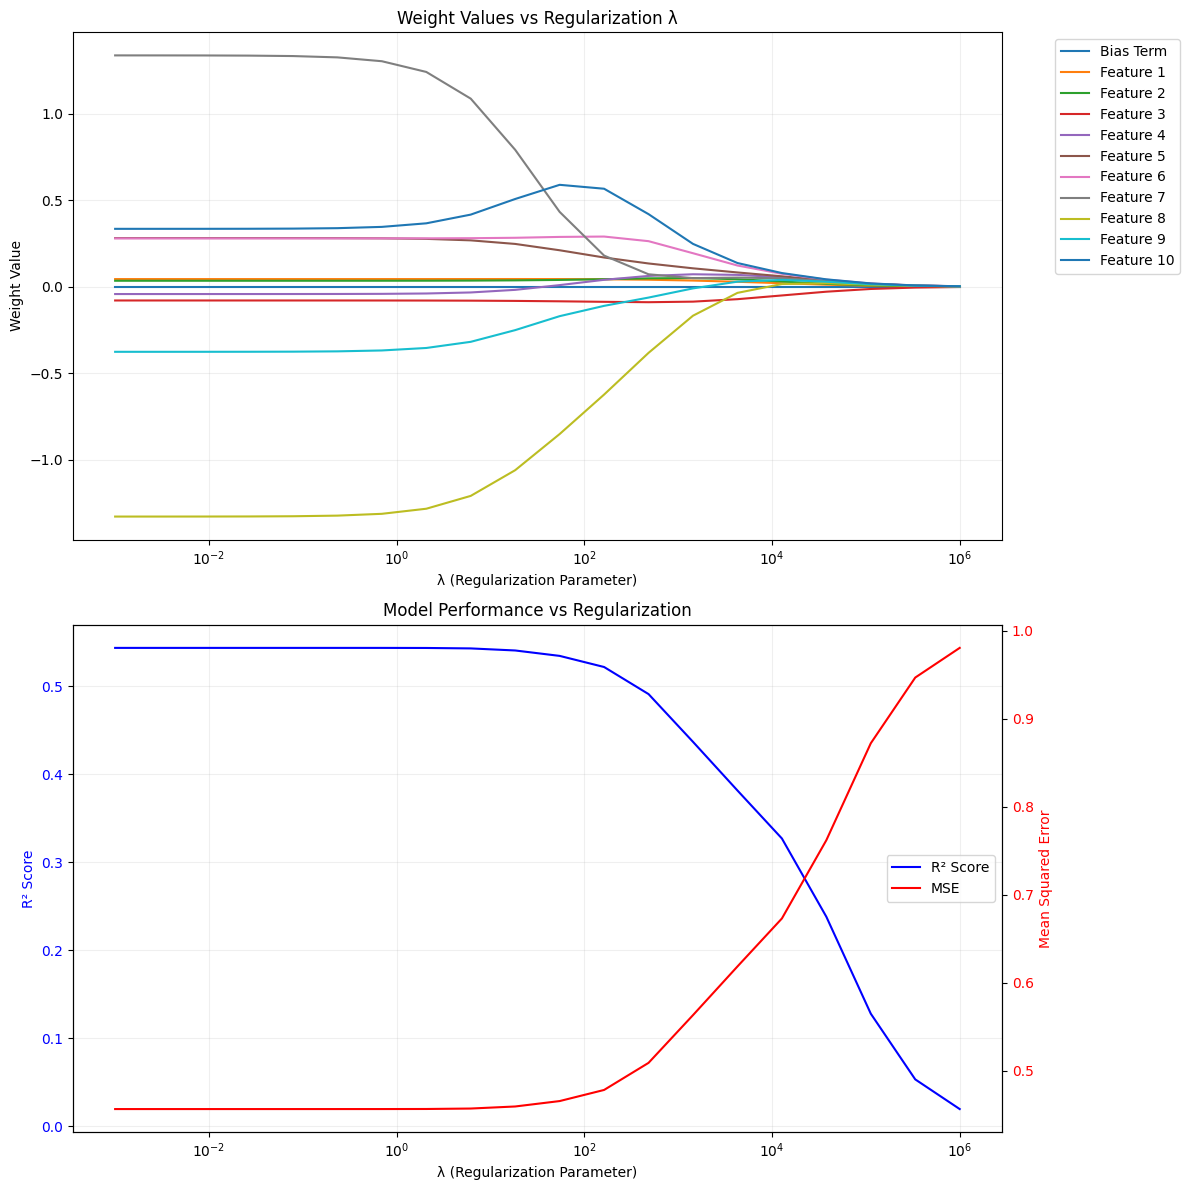

In [25]:
model.plot_regularization_effects(lambda_range=(-3, 6), n_samples=20)

### 1.2.3. Cross-validation and general estimated error
The next step is to use the K-fold cross-validation to estimate the general error of the model.

Optimal lambda: 0.3039195382313198
Lowest MSE: 0.4592710718430603


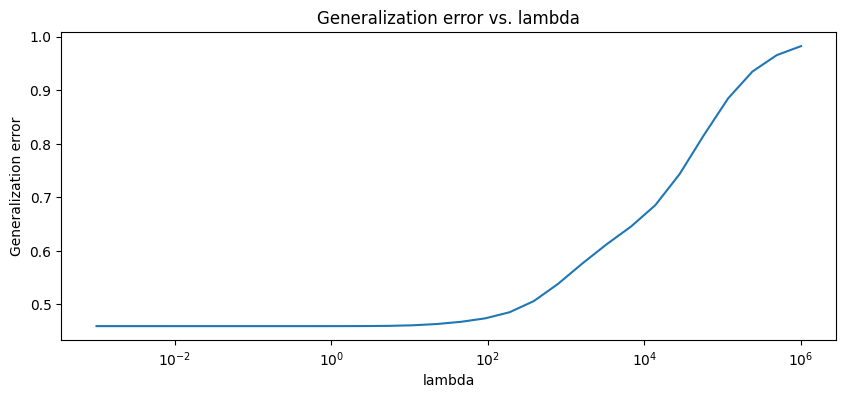

In [26]:
model.plot_one_level_cv_generalization_error()

ExactExplainer explainer: 836it [00:11, 11.61it/s]                         


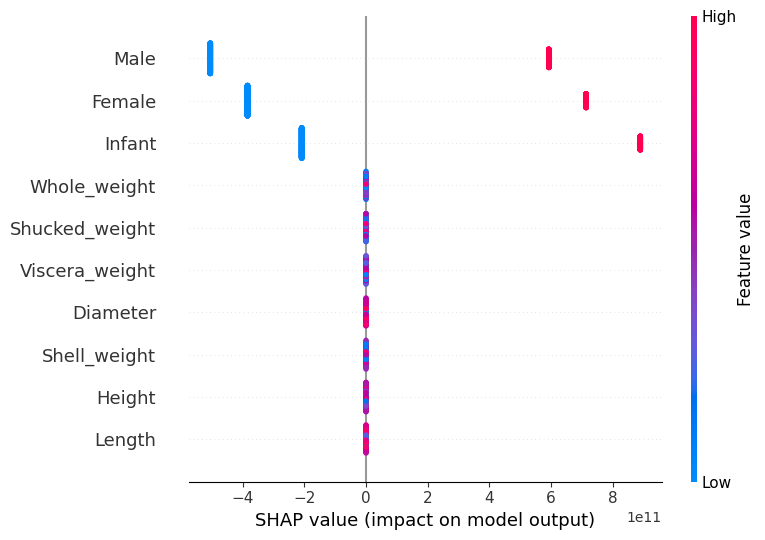

In [27]:
import shap
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression as LR
import pandas as pd

X_shap, y_shap = standardized_data[:, :-1], standardized_data[:, -1:]
y_shap = pd.Series(y_shap[:,0])

feature_names = ['Male', 'Female', 'Infant'] + abalone.variables.name.to_numpy()[1:-1].tolist()
#X_shap, y_shap = encoded_data[:, :-1], encoded_data[:, -1:]

X_shap = pd.DataFrame(X_shap, columns=feature_names)
for i in range(X_shap.shape[0]):
    X_shap.values[i, 0] = float(X_shap.values[i, 0])
    X_shap.values[i, 1] = float(X_shap.values[i, 1])
    X_shap.values[i, 2] = float(X_shap.values[i, 2])
    
for i in range(X_shap.shape[0]):
    for j in range(X_shap.shape[1]):
        assert isinstance(X_shap.values[i, j], (float))
        
X_train, X_test, y_train, y_test = train_test_split(X_shap, y_shap, test_size=0.2, random_state=42)

X_train = X_train.astype(float)
X_test = X_test.astype(float)

# a simple linear model
model = LR()
model.fit(X_train, y_train)

# Fits the explainer
explainer = shap.Explainer(model.predict, X_test)
# Calculates the SHAP values - It takes some time
shap_values = explainer(X_test)

# Select attributes (zero-indexed: 0 to 10)
selected_indices = slice(0, 10)

# Get the relevant SHAP values and feature names
shap_values_subset = shap_values[:, selected_indices]
X_test_subset = X_test.iloc[:, selected_indices]

# Plot SHAP values for the selected features
shap.summary_plot(shap_values_subset, X_test_subset, feature_names=X_test.columns[selected_indices])

In [28]:
from scipy.special import softmax

def print_feature_importances_shap_values(shap_values, features):
    # Calculates the feature importance (mean absolute shap value) for each feature
    importances = []
    for i in range(shap_values.values.shape[1]):
        importances.append(np.mean(np.abs(shap_values.values[:, i])))
        
    # Calculates the normalized version
    importances_norm = softmax(importances)
    
    # Organize the importances and columns in a dictionary
    feature_importances = {fea: imp for imp, fea in zip(importances, features)}
    feature_importances_norm = {fea: imp for imp, fea in zip(importances_norm, features)}
    
    # Sorts the dictionary
    feature_importances = {k: v for k, v in sorted(feature_importances.items(), key=lambda item: item[1], reverse = True)}
    feature_importances_norm= {k: v for k, v in sorted(feature_importances_norm.items(), key=lambda item: item[1], reverse = True)}
    
    # Prints the feature importances
    for k, v in feature_importances.items():
        print(f"{k} -> {v:.4f}")

print_feature_importances_shap_values(shap_values, feature_names)

Male -> 537646939734.7388
Female -> 487235148821.2255
Infant -> 419415064198.9236
Whole_weight -> 1.1855
Shucked_weight -> 1.0911
Viscera_weight -> 0.3326
Diameter -> 0.2972
Shell_weight -> 0.2392
Height -> 0.2370
Length -> 0.0999


- - -
## 1.3. Considerations

### 1.3.1. 
Explain how the output, $y$, of the linear model with the lowest generalization error (as determined in the previous question) is computed for a given input $x$. 

### 1.3.2. 
What is the effect of an individual attribute in $x$ on the output, $y$, of the linear model?

### 1.3.3. 
Does the effect of individual attributes make sense based on your understanding of the problem?

- - -
- - -

# 2. Regression (part 2)

In this section, we will compare three models: the regularized linear regression model from the previous section, an artificial neural network (ANN) and a baseline. We are interested in two questions: Is one model better than the other? Is either model better than a trivial baseline?. We will attempt to answer these questions with two-level cross-validation.

## 2.1. Building the models

### 2.1.1. Baseline model

As a baseline, we will use a linear regression model without features, that predicts the output for each test data always as the average of the training data.
But since it's just a simple calculation, we will perform it directly in the cross-validation function.

### 2.1.2. Artificial Neural Networks (ANN)

In [29]:
import torch
# import torch.nn as nn
# import torch.optim as optim

In [30]:
from DataLoader import DataLoader
from Regression.ANNRegression import ANNRegression

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

- - -
## 2.2. Comparing the performance

### 2.2.1. Two-level cross-validation

In [31]:
batch_size = 128
num_epochs = 50
criterion = torch.nn.MSELoss()

def two_level_cross_validation(lambdas, hidden_neurons, outer_K, inner_K):
    baseline_mse_scores = []
    lr_outer_mse_scores = []
    ann_outer_mse_scores = []
    
    outer_kf = KFold(n_splits=outer_K, shuffle=True, random_state=42)
    outer_folds = outer_kf.split(X)
    
    # outer folds
    for outer_train_index, outer_test_index in outer_folds:
        X_outer_train, X_outer_test = X[outer_train_index], X[outer_test_index]
        y_outer_train, y_outer_test = y[outer_train_index], y[outer_test_index]
        
        lr_avg_inner_mses = []
        ann_avg_inner_mses = []
        
        # calculate the inner folds before looping over the hyperparameters to ensure that its the same for each of them
        inner_kf = KFold(n_splits=inner_K, shuffle=True, random_state=42)
        inner_folds = inner_kf.split(X_outer_train)
        
        # for every hyperparameter value
        for j in range(len(lambdas)):
            lambda_ = lambdas[j]
            lr_inner_mse = 0
   
            hidden = hidden_neurons[j]
            ann_inner_mse = 0

            # inner folds
            for inner_train_index, inner_val_index in inner_folds:
                X_inner_train, X_inner_val = X_outer_train[inner_train_index], X_outer_train[inner_val_index]
                y_inner_train, y_inner_val = y_outer_train[inner_train_index], y_outer_train[inner_val_index]
                
                # Train the linear regression model
                lr_model = LinearRegression(X_inner_train, y_inner_train, include_bias=False)
                lr_model.solve_analytical(lambda_)
                lr_val_pred = np.dot(X_inner_val, lr_model.weights)
                lr_inner_mse += np.mean((y_inner_val - lr_val_pred) ** 2)
                    
                # Train the ANN model
                X_inner_train = torch.Tensor(X_inner_train.astype(np.float64)).to(device)
                y_inner_train = torch.Tensor(y_inner_train.astype(np.float64)).to(device)
                X_inner_val = torch.Tensor(X_inner_val.astype(np.float64)).to(device)
                y_inner_val = torch.Tensor(y_inner_val.astype(np.float64)).to(device)
                
                train_loader = DataLoader(X_inner_train, y_inner_train, batch_size=batch_size)
                val_loader = DataLoader(X_inner_val, y_inner_val, batch_size=batch_size)

                ann_model = ANNRegression(X_inner_train.shape[1], hidden).to(device)
                optimizer = torch.optim.Adam(ann_model.parameters(), lr=1e-3)
                ann_model.train_(device, train_loader, val_loader, optimizer, criterion, num_epochs)
                ann_val_pred = ann_model.predict(X_inner_val)
                ann_inner_mse += np.mean((y_inner_val.cpu().detach().numpy() - ann_val_pred.cpu().detach().numpy()) ** 2)
                    
            # calculate the average mse of the inner folds for the given hyperparameter value and add it to the list
            lr_avg_inner_mses.append(lr_inner_mse / inner_K)
            ann_avg_inner_mses.append(ann_inner_mse / inner_K) 

        # take the hyperparameter that gave the lowest average mse on the inner folds
        best_lambda = lambdas[np.argmin(ann_avg_inner_mses)]
        best_hidden = hidden_neurons[np.argmin(ann_avg_inner_mses)]
                    
        # Evaluate the baseline model
        y_train_outer_mean = np.mean(y_outer_train)
        y_test_pred = np.full_like(y_outer_test, y_train_outer_mean)
        baseline_mse = np.mean((y_outer_test - y_test_pred) ** 2)
        baseline_mse_scores.append({'mse': baseline_mse})
        
        # Train the linear regression model with the best lambda
        lr_model = LinearRegression(X_outer_train, y_outer_train, include_bias=False)
        lr_model.solve_analytical(best_lambda)
        # And evaluate it on the test set
        lr_test_pred = np.dot(X_outer_test, lr_model.weights)
        lr_outer_mse = np.mean((y_outer_test - lr_test_pred) ** 2)
        lr_outer_mse_scores.append({
            'lambda': best_lambda,
            'mse': lr_outer_mse
        })
        
        # Train the ANN model with the best number of hidden neurons
        X_outer_train = torch.Tensor(X_outer_train.astype(np.float64)).to(device)
        y_outer_train = torch.Tensor(y_outer_train.astype(np.float64)).to(device)
        X_outer_test = torch.Tensor(X_outer_test.astype(np.float64)).to(device)
        y_outer_test = torch.Tensor(y_outer_test.astype(np.float64)).to(device)
        
        train_loader = DataLoader(X_outer_train, y_outer_train, batch_size=batch_size)
        test_loader = DataLoader(X_outer_test, y_outer_test, batch_size=batch_size)

        ann_model = ANNRegression(X_outer_train.shape[1], best_hidden).to(device)
        optimizer = torch.optim.Adam(ann_model.parameters(), lr=1e-3)
        ann_model.train_(device, train_loader, test_loader, optimizer, criterion, num_epochs)
        
        # And evaluate it on the test set
        ann_test_pred = ann_model.predict(X_outer_test)
        ann_outer_mse = np.mean((y_outer_test.cpu().detach().numpy() - ann_test_pred.cpu().detach().numpy()) ** 2)
        ann_outer_mse_scores.append({
            'hidden': best_hidden,
            'mse': ann_outer_mse
        })
        
    return baseline_mse_scores, lr_outer_mse_scores, ann_outer_mse_scores

In [32]:
num_hyperparameter_values = 30

baseline_mse_scores, lr_outer_mse_scores, ann_outer_mse_scores = two_level_cross_validation(
    lambdas=np.logspace(-3, 6, num_hyperparameter_values), 
    hidden_neurons=[int(i) for i in range(1, num_hyperparameter_values + 1)],  
    outer_K=10,
    inner_K=10,
)

### 2.2.2 Creating a table

In [35]:
import pandas as pd
from IPython.display import display, HTML

data = pd.DataFrame({
    'Outer fold i': list(range(0, 10)),
    'h<sub>i</sub><sup>*</sup>': [ann_outer_mse_scores[i]["hidden"] for i in range(0, 10)],
    'ANN E<sub>i</sub><sup>test</sup>': [ann_outer_mse_scores[i]["mse"] for i in range(0, 10)],
    'λ<sub>i</sub><sup>*</sup>': [lr_outer_mse_scores[i]["lambda"] for i in range(0, 10)],
    'LR E<sub>i</sub><sup>test</sup>': [lr_outer_mse_scores[i]["mse"] for i in range(0, 10)],
    'Baseline E<sub>i</sub><sup>test</sup>': [baseline_mse_scores[i]["mse"] for i in range(0, 10)]
})

pd.set_option('display.float_format', lambda x: '{:.4f}'.format(x))
pd.set_option('display.max_columns', None)

style = """
<style>
    table {text-align: center !important;}
    th {text-align: center !important;}
    td {text-align: center !important;}
</style>
"""

display(HTML(style + data.to_html(escape=False)))

summary_data = {
    'ANN': [
        data['ANN E<sub>i</sub><sup>test</sup>'].min(),
        data['ANN E<sub>i</sub><sup>test</sup>'].mean(),
        data['ANN E<sub>i</sub><sup>test</sup>'].max()
    ],
    'Linear Regression': [
        data['LR E<sub>i</sub><sup>test</sup>'].min(),
        data['LR E<sub>i</sub><sup>test</sup>'].mean(),
        data['LR E<sub>i</sub><sup>test</sup>'].max()
    ],
    'Baseline': [
        data['Baseline E<sub>i</sub><sup>test</sup>'].min(),
        data['Baseline E<sub>i</sub><sup>test</sup>'].mean(),
        data['Baseline E<sub>i</sub><sup>test</sup>'].max()
    ]
}

summary_df = pd.DataFrame(
    summary_data,
    index=['Best', 'Average', 'Worst']
)

print("\nSummary Statistics (Test Loss):")
display(HTML(style + summary_df.round(4).to_html()))

,Outer fold i,hi*,ANN Eitest,λi*,LR Eitest,Baseline Eitest
0,0,2,0.5388,0.0020,0.4925,1.1547
1,1,2,0.4286,0.0020,0.4617,1.1495
2,2,2,0.4835,0.0020,0.4756,0.9129
3,3,2,0.4325,0.0020,0.3750,0.7947
4,4,2,0.5975,0.0020,0.5999,1.1620
5,5,2,0.4999,0.0020,0.4425,1.0075
6,6,2,0.5207,0.0020,0.4915,1.0976
7,7,2,0.4146,0.0020,0.4240,0.8595
8,8,2,0.4072,0.0020,0.3828,0.9664
9,9,2,0.4656,0.0020,0.4424,0.8981



Summary Statistics (Test Loss):


,ANN,Linear Regression,Baseline
Best,0.4072,0.3750,0.7947
Average,0.4789,0.4588,1.0003
Worst,0.5975,0.5999,1.1620


In [50]:
from sklearn.model_selection import RepeatedKFold

def stat_eval_cross_validation(X, y, lambda_=0.002, hidden_u=2, K=10, J=30):
    rkf = RepeatedKFold(n_splits=K, n_repeats=J // K, random_state=42)
    
    ann_vs_lr = []
    ann_vs_baseline = []
    lr_vs_baseline = []
    
    for train_index, test_index in rkf.split(X):
        X_train, X_test = X[train_index], X[test_index]
        y_train, y_test = y[train_index], y[test_index]
        
        # Evaluate the baseline model
        y_train_mean = np.mean(y_train)
        y_test_pred = np.full_like(y_test, y_train_mean)
        mse_baseline = np.mean((y_test - y_test_pred) ** 2)
        
        # Linear Regression
        lr_model = LinearRegression(X_train, y_train, include_bias=False)
        lr_model.solve_analytical(lambda_)
        y_pred = np.dot(X_test, lr_model.weights)
        mse_lr = np.mean((y_test - y_pred) ** 2)
        
        # ANN model
        X_train = torch.Tensor(X_train.astype(np.float64)).to(device)
        y_train = torch.Tensor(y_train.astype(np.float64)).to(device)
        X_test = torch.Tensor(X_test.astype(np.float64)).to(device)
        y_test = torch.Tensor(y_test.astype(np.float64)).to(device)
        
        train_loader = DataLoader(X_train, y_train, batch_size=128)
        test_loader = DataLoader(X_test, y_test, batch_size=128)

        ann_model = ANNRegression(X_train.shape[1], hidden_u).to(device)
        optimizer = torch.optim.Adam(ann_model.parameters(), lr=1e-3)
        ann_model.train_(device, train_loader, test_loader, optimizer, criterion, num_epochs)
        
        ann_test_pred = ann_model.predict(X_test)
        mse_ann = np.mean((y_test.cpu().detach().numpy() - ann_test_pred.cpu().detach().numpy()) ** 2)
        
        ann_vs_lr.append(mse_ann - mse_lr)
        ann_vs_baseline.append(mse_ann - mse_baseline)
        lr_vs_baseline.append(mse_lr - mse_baseline)
    
    """ avg_ann_vs_lr = np.mean(ann_vs_lr)
    avg_ann_vs_baseline = np.mean(ann_vs_baseline)
    avg_lr_vs_baseline = np.mean(lr_vs_baseline) """

    return ann_vs_lr, ann_vs_baseline, lr_vs_baseline

ann_vs_lr, ann_vs_baseline, lr_vs_baseline = stat_eval_cross_validation(X, y)

In [52]:
from dtuimldmtools import *
from dtuimldmtools.statistics.statistics import correlated_ttest

# Initialize parameters and run test appropriate for setup II
alpha = 0.05
rho = 1/10
p_ann_lr, CI_ann_lr = correlated_ttest(ann_vs_lr, rho, alpha=alpha)
p_ann_baseline, CI_ann_baseline = correlated_ttest(ann_vs_baseline, rho, alpha=alpha)
p_lr_baseline, CI_lr_baseline = correlated_ttest(lr_vs_baseline, rho, alpha=alpha)


print(p_ann_lr, CI_ann_lr)
print(p_ann_baseline, CI_ann_baseline)
print(p_lr_baseline, CI_lr_baseline)

0.22646769523259794 (-0.013310264995458058, 0.053949283463021434)
4.325769034091432e-14 (-0.5996977132556582, -0.4425986846738262)
4.129263384768509e-17 (-0.6038983934030026, -0.47903702299404477)


- - -
- - -

# 3. Classification

For classification, we will use the same setup as the first project, so we will use the gender as the target variable, since it's categroical, and the number of rings as a feature.

In [ ]:
abalone = fetch_ucirepo(id = 1)

data = abalone.data.original.to_numpy()

data = data[data[:, 3] != 0]
data = data[data[:, 3] < 0.5]
        
X, y = data[:, 1:], data[:, :1]
X = standardize_data(X)[0]

In [ ]:
from collections import Counter

def gender_encode_y(y):
    y_encoded = y.copy()
    
    # Mapping logic
    y_encoded[y == 'M'] = 1
    y_encoded[y == 'F'] = 1
    y_encoded[y == 'I'] = 0
    
    return y_encoded

def print_classes_and_counts(y):
    y_flat = y.flatten()
    
    class_counts = Counter(y_flat)
    
    print("\n\nClasses and their counts:")
    for cls, count in class_counts.items():
        print(f"Class: {cls}, Count: {count}")
        
    return class_counts

In [ ]:
y_binary = gender_encode_y(y)
y_binary = y_binary.astype(np.float64)
class_counts = print_classes_and_counts(y_binary)

## 3.1. Baseline model

The baseline model prediction is done by return the most frequent class in the training data.

In [ ]:
from Classification.BaselineClassification import BaselineClassification

model = BaselineClassification(y_binary)
model.train_()
E = model.eval_(y_binary)

## 3.2. Logistic regression for classification

In [ ]:
from Classification.LogisticRegression import LogisticRegression

# Split your data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y_binary, test_size=0.2, random_state=42)

# Initialize and train the model
model_bias = LogisticRegression(X_train, y_train, include_bias=True)
model_bias.train_()

model_nonbias = LogisticRegression(X_train, y_train, include_bias=False)
model_nonbias.train_()

print(f'Error rate without bias: {model_nonbias.eval_(X_test, y_test):.4f}, with bias: {model_bias.eval_(X_test, y_test):.4f}')

In [ ]:
model = LogisticRegression(X, y_binary)
model.plot_one_level_cv_generalization_error(lambda_range=(-5, 5), num_lambdas=100, K=10)
model.plot_one_level_cv_generalization_error(lambda_range=(2, 4.2), num_lambdas=100, K=10)
model.plot_one_level_cv_generalization_error(lambda_range=(3, 4), num_lambdas=100, K=10)

## 3.3. ANN, KNN, NB or CT

In [ ]:
from Classification.ANNClassification import ANNClassification

import torch.nn as nn
from sklearn.model_selection import train_test_split

# Device configuration
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Data Preparation
X_train, X_val, y_train, y_val = train_test_split(X, y_binary, test_size=0.8, random_state=42)
X_train_tensor = torch.FloatTensor(X_train).to(device)
y_train_tensor = torch.LongTensor(y_train.flatten()).to(device)
X_val_tensor = torch.FloatTensor(X_val).to(device)
y_val_tensor = torch.LongTensor(y_val.flatten()).to(device)

train_loader = DataLoader(X_train_tensor, y_train_tensor, batch_size=32, shuffle=True)
val_loader = DataLoader(X_val_tensor, y_val_tensor, batch_size=32, shuffle=False)

# Define the ANNClassification model
input_size = X.shape[1]
hidden_neurons = 2
model = ANNClassification(input_size, hidden_neurons).to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

# Train the model
num_epochs = 50
model.train_(device, train_loader, optimizer, criterion, num_epochs)

# Evaluate accuracy on validation set
val_loss, val_error = model.eval_(device, val_loader, criterion)

In [ ]:
model.plot_training_loss()

## 3.4. Two-level cross-validation for classification

In [ ]:
import pandas as pd

batch_size = 128
num_epochs = 50
criterion = nn.CrossEntropyLoss()
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

def classification_two_level_cross_validation(X, y, lambdas, hidden_neurons, outer_K, inner_K):
    cv_table_df = pd.DataFrame(columns=['Outer Fold', 'ANN_h', 'ANN_error', 'LR_lambda', 'LR_error', 'Baseline_error'])

    outer_kf = KFold(n_splits=outer_K, shuffle=True, random_state=42)
    outer_folds = outer_kf.split(X)
    
    # outer folds
    for outer_fold, (outer_train_index, outer_test_index) in enumerate(outer_folds):
        X_outer_train, X_outer_test = X[outer_train_index], X[outer_test_index]
        y_outer_train, y_outer_test = y[outer_train_index], y[outer_test_index]
        
        lr_avg_inner_mses = []
        ann_avg_inner_mses = []

        # calculate the inner folds before looping over the hyperparameters to ensure that its the same for each of them
        inner_kf = KFold(n_splits=inner_K, shuffle=True, random_state=42)
        inner_folds = inner_kf.split(X_outer_train)
        
        # for every hyperparameter value
        for j in range(len(lambdas)):
            lambda_ = lambdas[j]
            lr_inner_mse = 0
            
            hidden = hidden_neurons[j]
            ann_inner_mse = 0
            
            # inner folds
            for inner_train_index, inner_val_index in inner_folds:
                X_inner_train, X_inner_val = X_outer_train[inner_train_index], X_outer_train[inner_val_index]
                y_inner_train, y_inner_val = y_outer_train[inner_train_index], y_outer_train[inner_val_index]

                # Train the log regression model
                lr_model = LogisticRegression(X_inner_train, y_inner_train, lambda_=lambda_, include_bias=True)
                lr_model.train_()
                lr_inner_mse += lr_model.eval_(X_inner_val, y_inner_val)
                    
                #ANN model
                X_inner_train = torch.Tensor(X_inner_train.astype(np.float64)).to(device)
                y_inner_train = torch.LongTensor(y_inner_train.flatten()).to(device)
                X_inner_val = torch.Tensor(X_inner_val.astype(np.float64)).to(device)
                y_inner_val = torch.LongTensor(y_inner_val.flatten()).to(device)

                train_loader = DataLoader(X_inner_train, y_inner_train, batch_size=batch_size)
                val_loader = DataLoader(X_inner_val, y_inner_val, batch_size=batch_size)

                ann_model = ANNClassification(X_inner_train.shape[1], hidden).to(device)
                optimizer = torch.optim.Adam(ann_model.parameters(), lr=1e-3)
                ann_model.train_(device, train_loader, optimizer, criterion, num_epochs)
                ann_inner_mse += ann_model.eval_(device, val_loader, criterion)[1]
                
            # calculate the average mse of the inner folds for the given hyperparameter value and add it to the list
            lr_avg_inner_mses.append(lr_inner_mse / inner_K)
            ann_avg_inner_mses.append(ann_inner_mse / inner_K) 
            
        # take the hyperparameter that gave the lowest average mse on the inner folds
        best_lambda = lambdas[np.argmin(ann_avg_inner_mses)]
        best_hidden = hidden_neurons[np.argmin(ann_avg_inner_mses)]

        # Evaluate the baseline model
        baseline_model = BaselineClassification(y_outer_test)
        baseline_model.train_()
        error = baseline_model.eval_(y_outer_test)
        cv_table_df.loc[outer_fold, 'Baseline_error'] = error

        # Train the log regression model with the best lambda
        lr_model = LogisticRegression(X_outer_train, y_outer_train, include_bias=True)
        lr_model.train_()
        error = lr_model.eval_(X_outer_test, y_outer_test)
        cv_table_df.loc[outer_fold, 'LR_lambda'] = f"{np.log10(best_lambda):.2f}"
        cv_table_df.loc[outer_fold, 'LR_error'] = error

        # Train the ANN model with the best number of hidden neurons
        X_outer_train = torch.Tensor(X_outer_train.astype(np.float64)).to(device)
        y_outer_train = torch.Tensor(y_outer_train.astype(np.float64)).to(device)
        X_outer_test = torch.Tensor(X_outer_test.astype(np.float64)).to(device)
        y_outer_test = torch.Tensor(y_outer_test.astype(np.float64)).to(device)
        
        train_loader = DataLoader(X_outer_train, y_outer_train, batch_size=batch_size)
        test_loader = DataLoader(X_outer_test, y_outer_test, batch_size=batch_size)
        
        ann_model = ANNClassification(X_outer_train.shape[1], best_hidden).to(device)
        optimizer = torch.optim.Adam(ann_model.parameters(), lr=1e-3)
        ann_model.train_(device, train_loader, optimizer, criterion, num_epochs)

        # And evaluate it on the test set
        error = ann_model.eval_(device, test_loader, criterion)[1]
        cv_table_df.loc[outer_fold, 'ANN_h'] = best_hidden
        cv_table_df.loc[outer_fold, 'ANN_error'] = error
        cv_table_df.loc[outer_fold, 'Outer Fold'] = outer_fold + 1
   
    return cv_table_df

In [ ]:
num_hyperparameter_values = 30

df = classification_two_level_cross_validation(
    X=X,
    y=y_binary,
    lambdas=np.logspace(-3, 6, num_hyperparameter_values), 
    hidden_neurons=[int(i) for i in range(1, num_hyperparameter_values + 1)],  
    outer_K=10,
    inner_K=10,
)

display(df)

- - -
- - -
# Exercises

### Exercise 1
The subplot that corresponds to the ROC curve is C, because decreasing the threshold starting from $1.0$, the first point that become predicted as poisitve is a true positive, so the ROC curve moves up, then we have two points that become predicted as positive, but are in fact false positives, so the ROC curve moves right twice, and so on, tracing the curve in the figure.

### Exercise 2
The impurity gain of the split is $\Delta\approx 0.0148$, because:

$$
\begin{align}
\Delta
&=I(r)-\displaystyle\sum_{i=1}^K\frac{N_i}{N}I(v_i)=\\
&=\left(1-\dfrac{37}{37+31+33+34}\right)-\left[\dfrac{120}{135}\left(1-\dfrac{33}{33+28+30+29}\right)+\dfrac{14}{135}\left(1-\dfrac5{4+2+3+5}\right)+\dfrac1{135}\left(1-\dfrac11\right)\right]=\\
&=\dfrac{98}{135}-\left[\dfrac{120}{135}\dfrac{87}{120}+\dfrac{14}{135}\dfrac{9}{14}+\dfrac{1}{135}\cdot0\right]=\\
&=\dfrac{98}{135}-\dfrac{96}{135}=\\
&=\dfrac2{135}\approx0.0148
\end{align}
$$

### Exercise 3
The network contains $110$ parameters, because the input layer has $7$ neurons, the hidden layer has $10$ neurons, and the output layer has $4$ neurons, so the weights are $7\times 10+10\times 4=110$.

### Exercise 4
The correct rules assignment to the nodes are the ones described in D, because A separates $b_1<-0.76$ from $b_1>-0.76$, B separates the top-left region (congestion level 2) from the bottom-left region (congestion level 1), then C separates the right-most region (congestion level 4) from the middle strip, which is finally separated by D into middle-top (congestion level 1) and middle-bottom (congestion level 3).

### Exercise 5


### Exercise 6
The observation assigned to class $y=4$ will be observation B, because:
- $\hat y_1=\begin{bmatrix}1\\-0.6\\-1.6\end{bmatrix}^T\begin{bmatrix}1.2\\-2.1\\3.2\end{bmatrix}=-2.66$
- $\hat y_2=\begin{bmatrix}1\\-0.6\\-1.6\end{bmatrix}^T\begin{bmatrix}1.2\\-1.7\\2.9\end{bmatrix}=-2.42$
- $\hat y_3=\begin{bmatrix}1\\-0.6\\-1.6\end{bmatrix}^T\begin{bmatrix}1.3\\-1.1\\2.2\end{bmatrix}=-1.56$

So $P(y=4|\hat{\textbf{y}})=\dfrac1{1+e^{-2.66}+e^{-2.42}+e^{-1.56}}\approx0.74$ (being more than $0.5$ makes useless to calculate the probability of the other classes).

- - -
- - -